In [1]:
library("readxl")

Warning message:
"package 'readxl' was built under R version 3.6.3"

In [2]:
library("lubridate")
library('tidyr')
library('ggplot2')

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union

Warning message:
"package 'tidyr' was built under R version 3.6.3"

In [3]:
search()

[1] ".GlobalEnv"        "package:ggplot2"   "package:tidyr"    
 [4] "package:lubridate" "package:readxl"    "jupyter:irkernel" 
 [7] "jupyter:irkernel"  "package:stats"     "package:graphics" 
[10] "package:grDevices" "package:utils"     "package:datasets" 
[13] "package:methods"   "Autoloads"         "package:base"

In [4]:
source("helpers.R")

In [5]:
path <- "../data/data.xlsx"

In [6]:
df <- Dataframing(path)

In [7]:
df <- df[-c(210),]

In [8]:
df$Date <- as.Date(df$Date)

In [9]:
firstYields <- df[df$Date == "2022-02-11",]

In [10]:
firstYields

,Date,10Y,7Y,5Y,3Y,2Y,1Y,6M,3M
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
209,2022-02-11,1.941,1.94,1.856,1.728,1.505,1.029,0.692,0.359


#### Suponemos que: 
- $\alpha_1$ representa la tasa forward entre 0 y 3 meses, 
- $\alpha_2$ la tasa entre 3 meses y 1 año, 
- $\alpha_3$ la tasa entre 1 y 3 años,
- $\alpha_4$ la tasa entre 3 y 5 años ,
- $\alpha_5$ la tasa entre 5 y 10 años. 

In [11]:
today <- firstYields$Date

#### Además, para traer a valor presente usando una curva forward, se sigue el factor de descuento a un plazo T es: 

### $$ e^{-\int_{0}^{T} f(t) \,dt}$$

#### Definamos algunos objetos de utilidad. Cuántos cupones paga cada bono? Cómo ajustamos la tasa para cada pago?

In [12]:
alpha <- c(0.1,0.11,0.12,0.13,0.14)

[1] 0.10 0.11 0.12 0.13 0.14

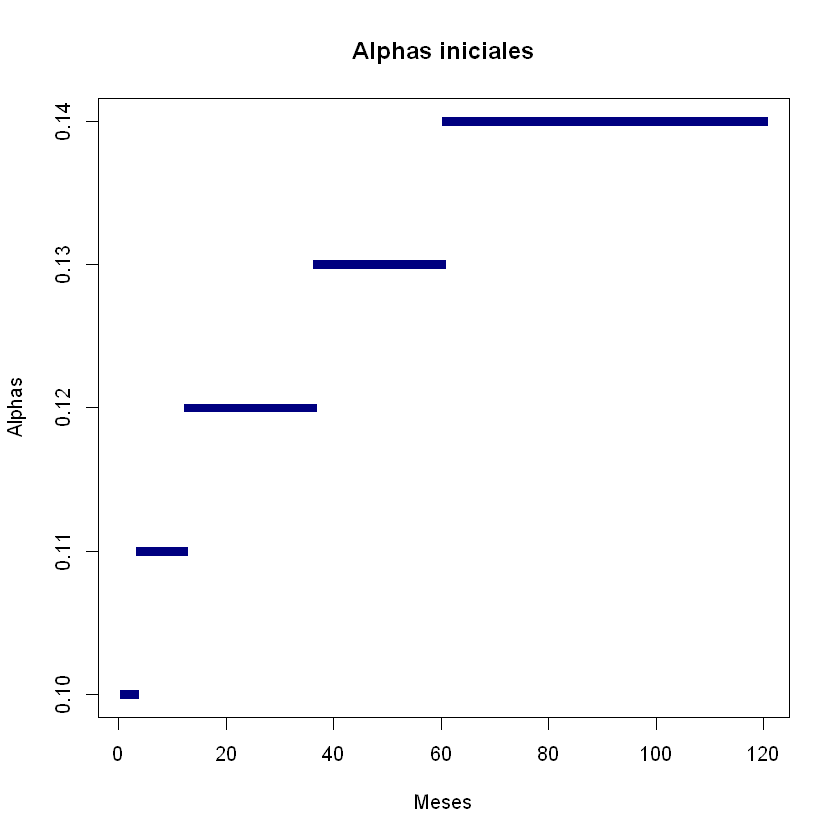

In [13]:
alpha
xx <- c(1:120)
aa <- alphacuts(alpha)
plot(xx,aa, type= "p",
            pch=22, 
            bg = "navy", 
            col = "navy", 
            main= "Alphas iniciales", 
            xlab = "Meses", 
            ylab = "Alphas")

In [14]:
today = firstYields$Date

In [15]:
threeMonthBond <- 100 + RateConverter(firstYields[["3M"]],3,today)*DiscountFactor(alpha, 3)
threeMonthBond
RateConverter(firstYields[["3M"]],3,today)

RateConverter(firstYields[["1Y"]],12,today)


[1] 100.0192

[1] 0.01970469

[1] 0.4303246

In [16]:
sixMonthBond <- 100 + RateConverter(firstYields[["6M"]], 6, today)*DiscountFactor(alpha, 6)

In [17]:
sixMonthBond

[1] 100.1435

In [18]:
oneYearBond <- 100 +  RateConverter(firstYields[["1Y"]], 6, today) *DiscountFactor(alpha, 6) + RateConverter(firstYields[["1Y"]], 12, today)*DiscountFactor(alpha, 12)

In [19]:
oneYearBond

[1] 100.5889

In [20]:
maturity<- 36

In [21]:
periods <- seq(6, maturity, 6)

In [22]:
threeMonthBond

[1] 100.0192

Recordemos que cada pago está dado por :  

$$\$100\times R \times \frac{ACT}{360}$$

In [23]:
singleBondPayment <- function(maturity, yield, alpha, today){
    return (RateConverter(yield, maturity,today)*DiscountFactor(alpha, maturity))
}

In [24]:
singleBondPayment(120,firstYields[["10Y"]], alpha, today)
firstYields[["10Y"]]

[1] 1.961799

[1] 1.941

In [25]:
yieldList <- list(firstYields)

In [26]:
nombres <- colnames(firstYields)

In [27]:
nombres <- nombres[-1]

In [28]:
nombres

[1] "10Y" "7Y"  "5Y"  "3Y"  "2Y"  "1Y"  "6M"  "3M"

In [29]:
nombres <- as.list(nombres)

In [30]:
names(nombres) <- c(120,84,60,36,24,12,6,3) 

In [31]:
BondValue <- function (today, maturity, yieldlist,alpha ){
    if (maturity == 3){
        return (100*DiscountFactor(alpha, maturity) + singleBondPayment(3,yieldlist[["3M"]], alpha, today))
        }
    setter <- as.character(maturity)
    periods <- seq(6, maturity, 6)
    bondSum <- sum(unlist(lapply(periods, function(x) singleBondPayment(x, yield = yieldlist[[nombres[[setter]]]],  alpha = alpha, today = today))))
    return(bondSum +100*DiscountFactor(alpha, maturity))
}



In [32]:
BondValue(today, 120, firstYields, alpha)

[1] 60.82667

In [33]:
maturities <- c(120,84,60,36,24,12,6,3) 

In [34]:
alpha <- c(0.00343, 0.0105, 0.0817, 0.1598, 0.2744)
bondValues <- list()
for (i in maturities){
    bondValues <- append(bondValues, BondValue(today, i, firstYields, alpha))
}

In [35]:
bondValues

[[1]]
[1] 47.00202

[[2]]
[1] 58.45278

[[3]]
[1] 75.90743

[[4]]
[1] 90.43397

[[5]]
[1] 94.15173

[[6]]
[1] 99.76979

[[7]]
[1] 99.80305

[[8]]
[1] 99.93397

In [36]:
error <-function(alpha){
    maturities <- c(3,6,12,24,36,60,84,120) 
    bondValues <- list()
    for (i in maturities){
        bondValues <- append(bondValues, BondValue(today, i, firstYields, alpha))
    }
    error <- sum((unlist(bondValues)-100)**2)
    return (error)
}

error(alpha)

[1] 5241.216

In [37]:
opt <- optim(alpha, error, lower = 0, upper= 1, method = "L-BFGS-B")

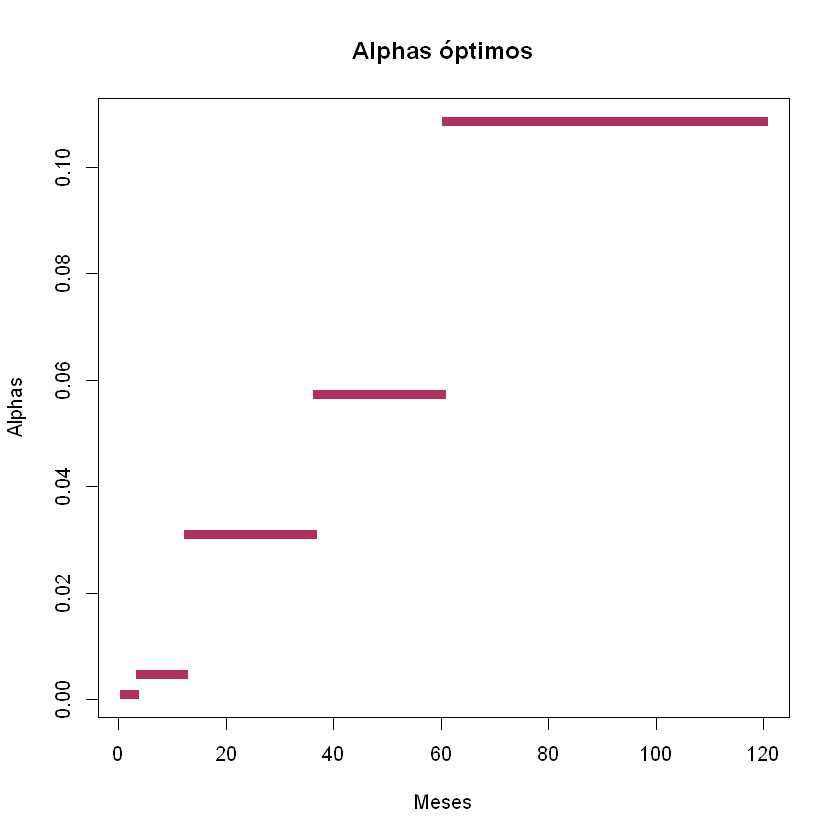

In [38]:
alpha <- opt$par

xx <- c(1:120)
aa <- alphacuts(alpha)
plot(xx,aa, type= "p",
            pch=22, 
            bg = "maroon", 
            col = "maroon", 
            main= "Alphas óptimos", 
            xlab = "Meses", 
            ylab = "Alphas")

Valoración de bono de 7 años

In [39]:
alpha <- opt$par
pvnotional <- 100 - DiscountFactor(alpha[4], 84)*100
pvnotional
couponsum <- function (c){
pvcoupon <- DiscountFactor(alpha[2], 12)*RateConverter(c, 12,today) + DiscountFactor(alpha[2], 24)*RateConverter(c,24,today) +
 DiscountFactor(alpha[3], 36)*RateConverter(c, 36,today) +DiscountFactor(alpha[3], 48)*RateConverter(c, 48,today) +
 DiscountFactor(alpha[4], 60)*RateConverter(c, 60,today) + DiscountFactor(alpha[4], 72)*RateConverter(c, 72,today) +  
 DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today) + DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today)
 result <-pvnotional- pvcoupon
    if (result <0){
        return (500)
    }
    else {
        return (pvnotional- pvcoupon)
    }
    
}

opti <- optim(c,couponsum,lower = 0, upper=10,  method = "Brent")
opti


[1] 33.02606

$par
[1] 3.939572

$value
[1] 6.409757e-07

$counts
function gradient 
      NA       NA 

$convergence
[1] 0

$message
NULL

Matriz de curvas 3 años en el pasado

In [40]:

matAlphas <- list()
df <- df[(nrow(df)-52):nrow(df),]
for ( r in 1:nrow(df)){ 
    firstYields <- df[r,]
    today <- firstYields$Date
    alpha <- opt$par
    opt <- optim(alpha, error, lower = 0, upper= 1, method = "L-BFGS-B")
    matAlphas <- append(matAlphas, list(opt$par))
}

In [41]:
MatofAlphas <- matrix(unlist(matAlphas), ncol = 5, byrow = TRUE)
MatofAlphas

0.000000e+00,0.000000e+00,0.004479686,0.01840584,0.09237962
0.000000e+00,0.000000e+00,0.004706973,0.02325406,0.09939886
0.000000e+00,0.000000e+00,0.006106605,0.03171539,0.10005125
0.000000e+00,0.000000e+00,0.006740605,0.03408690,0.10965080
0.000000e+00,0.000000e+00,0.007353796,0.03552450,0.11252459
0.000000e+00,0.000000e+00,0.007191029,0.03778698,0.11806777
0.000000e+00,0.000000e+00,0.006776310,0.03766010,0.11542087
0.000000e+00,0.000000e+00,0.008363223,0.04205166,0.11554998
0.000000e+00,0.000000e+00,0.007303816,0.03692244,0.11421266
0.000000e+00,0.000000e+00,0.007467144,0.03518958,0.10970437
0.000000e+00,0.000000e+00,0.007301729,0.03480937,0.10857967


In [42]:
write.csv(MatofAlphas,"../data/sim.csv", row.names = FALSE)

In [43]:
MatofAlphas <- read.csv("../data/sim.csv")
i_alpha <- MatofAlphas[-nrow(MatofAlphas),]
f_alpha <- MatofAlphas[-1,]
delta_alpha <- f_alpha - i_alpha
cov_delta_a <- cov(delta_alpha)
MatofAlphas
cov_delta_a

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000000e+00,0.000000e+00,0.004479686,0.01840584,0.09237962
0.000000e+00,0.000000e+00,0.004706973,0.02325406,0.09939886
0.000000e+00,0.000000e+00,0.006106605,0.03171539,0.10005125
0.000000e+00,0.000000e+00,0.006740605,0.03408690,0.10965080
0.000000e+00,0.000000e+00,0.007353796,0.03552450,0.11252459
0.000000e+00,0.000000e+00,0.007191029,0.03778698,0.11806777
0.000000e+00,0.000000e+00,0.006776310,0.03766010,0.11542087
0.000000e+00,0.000000e+00,0.008363223,0.04205166,0.11554998
0.000000e+00,0.000000e+00,0.007303816,0.03692244,0.11421266


,V1,V2,V3,V4,V5
V1,2.263518e-07,-1.770099e-07,1.559447e-08,1.711553e-08,5.427058e-08
V2,-1.770099e-07,2.357452e-07,6.295578e-08,1.538140e-08,-7.867548e-09
V3,1.559447e-08,6.295578e-08,1.567100e-06,2.416956e-06,1.921950e-06
V4,1.711553e-08,1.538140e-08,2.416956e-06,7.320522e-06,7.321334e-06
V5,5.427058e-08,-7.867548e-09,1.921950e-06,7.321334e-06,1.759335e-05


In [44]:
eigen_delta <- eigen(cov_delta_a)
A <- eigen_delta$vectors 
sqrt <- sqrt(eigen_delta$values)
A 
sqrt
B <- t(t(A)*sqrt)
B

0.002665869,0.00219449,0.03159736,0.703379734,0.710103256
0.000395984,-0.01072731,-0.13662533,-0.700696616,0.700173221
0.138663191,-0.39234767,-0.89971081,0.111675472,-0.069891854
0.465326709,-0.78463804,0.40670376,-0.042432518,0.024611616
0.874206103,0.47988182,-0.07380809,0.003045109,-0.004497011


[1] 0.0046685549 0.0020128460 0.0008007647 0.0006358969 0.0002247929

1.244576e-05,4.417170e-06,2.530205e-05,4.472770e-04,1.596262e-04
1.848673e-06,-2.159243e-05,-1.094047e-04,-4.455708e-04,1.573940e-04
6.473567e-04,-7.897355e-04,-7.204566e-04,7.101409e-05,-1.571119e-05
2.172403e-03,-1.579356e-03,3.256740e-04,-2.698271e-05,5.532517e-06
4.081279e-03,9.659282e-04,-5.910291e-05,1.936375e-06,-1.010896e-06


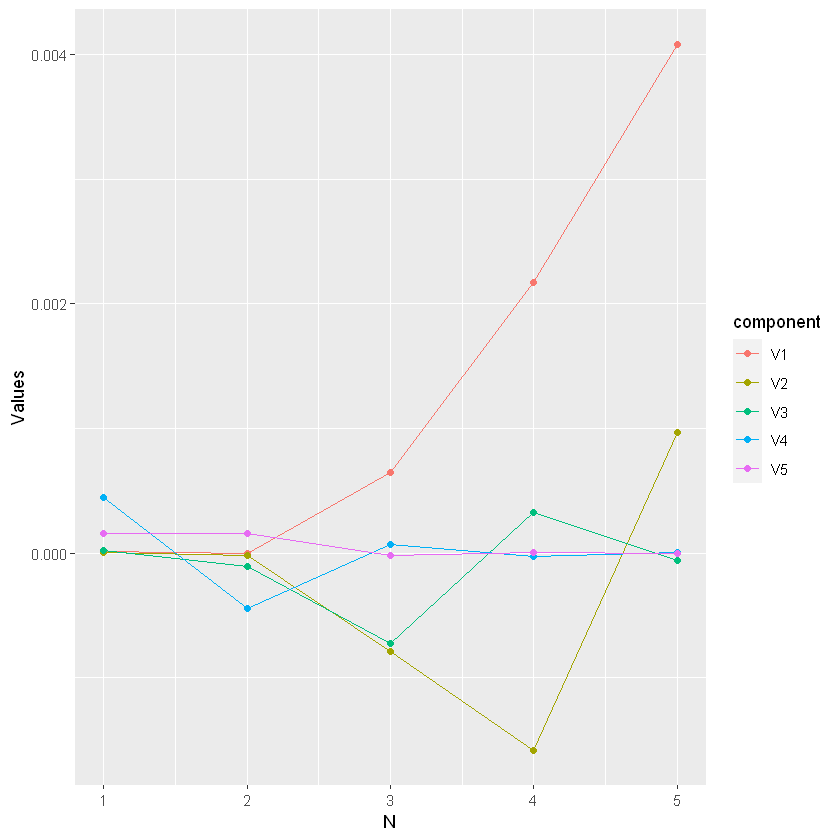

In [45]:
Bbase <- as.data.frame(B)
Bbase$N <- c(1,2,3,4,5)
Bbase <- pivot_longer(Bbase, cols=1:5,names_to= "component", values_to='Values')
ggplot(Bbase, aes(x = N, y = Values, color = component)) + 
  geom_line() +
  geom_point()

In [46]:
Y <- MatofAlphas*A
Y

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000000e+00,0.000000e+00,-4.805499e-05,8.832627e-03,-8.311495e-02
0.000000e+00,0.000000e+00,-1.846770e-03,7.347669e-04,4.042589e-02
0.000000e+00,0.000000e+00,-4.791474e-03,-4.333126e-03,-7.384592e-03
0.000000e+00,0.000000e+00,3.234694e-03,-3.066835e-02,7.712615e-02
0.000000e+00,0.000000e+00,2.323605e-04,1.444795e-02,-7.884560e-02
0.000000e+00,0.000000e+00,-9.824767e-04,-2.788985e-03,1.318527e-02
0.000000e+00,0.000000e+00,-6.096719e-03,2.648935e-02,-4.897598e-03
0.000000e+00,0.000000e+00,3.401354e-03,-2.946546e-02,3.518623e-04
0.000000e+00,0.000000e+00,-5.390807e-04,4.123331e-03,8.110278e-02


In [47]:
W <- MatofAlphas*B
W

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000000e+00,0.000000e+00,-9.672730e-08,1.777872e-05,-6.655551e-05
0.000000e+00,0.000000e+00,-3.717263e-06,5.883754e-07,3.237163e-05
0.000000e+00,0.000000e+00,-9.644500e-06,-3.469814e-06,-5.913320e-06
0.000000e+00,0.000000e+00,6.510941e-06,-2.455813e-05,4.904428e-05
0.000000e+00,0.000000e+00,1.860661e-07,1.156941e-05,-5.013767e-05
0.000000e+00,0.000000e+00,-7.867326e-07,-2.233321e-06,8.384475e-06
0.000000e+00,0.000000e+00,-4.882037e-06,1.684449e-05,-3.114367e-06
0.000000e+00,0.000000e+00,2.723684e-06,-1.873699e-05,2.237481e-07
0.000000e+00,0.000000e+00,-4.316768e-07,2.622013e-06,1.823133e-05


En los siguientes pasos se estiman los componentes principales por medio del comando princomp()

In [48]:
components <- princomp(delta_alpha)
summary(components)

Importance of components:
                            Comp.1      Comp.2       Comp.3       Comp.4
Standard deviation     0.004623447 0.001993398 0.0007930276 0.0006297528
Proportion of Variance 0.808942742 0.150374419 0.0237992168 0.0150081184
Cumulative Proportion  0.808942742 0.959317161 0.9831163773 0.9981244957
                             Comp.5
Standard deviation     0.0002226209
Proportion of Variance 0.0018755043
Cumulative Proportion  1.0000000000

In [49]:
cum_variance <- cumsum(components$sdev^2 / sum(components$sdev^2))
best_components <- components$scores[,1:2]

Comp.1    Comp.2    Comp.3    Comp.4    Comp.5 
0.8089427 0.9593172 0.9831164 0.9981245 1.0000000

,Comp.1,Comp.2
2,7.732720e-03,1.135492e-04
3,4.010615e-03,-6.236736e-03
4,8.892358e-03,3.135544e-03
5,2.575205e-03,6.489170e-04
6,5.185036e-03,1.587125e-03
7,-3.121548e-03,-3.695086e-04
8,1.685362e-03,-3.368033e-03
9,-4.393828e-03,4.436899e-03
10,-5.415934e-03,-2.294397e-04
11,-1.874146e-03,4.619275e-04


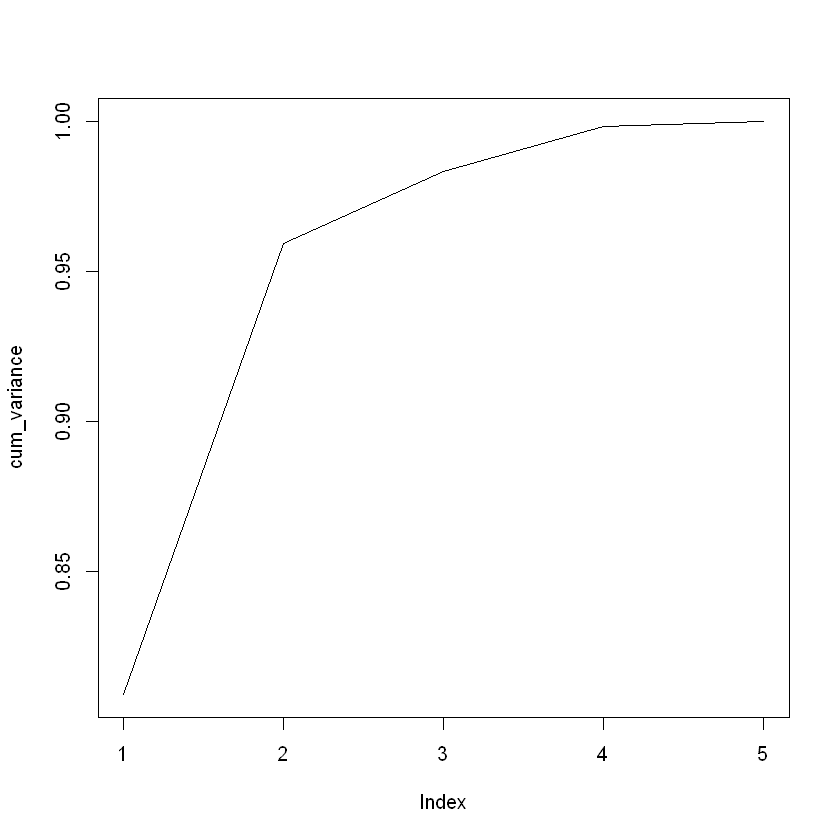

In [50]:
cum_variance
plot(cum_variance, type='l')
best_components

In [51]:
librerias <- c("forecast","xts","rugarch","timeSeries","ggplot2","astsa","scales","lubridate","reshape2","quantmod","xtable","tseries")

In [52]:
if(length(setdiff(librerias, rownames(installed.packages()))) > 0){
  install.packages(setdiff(librerias, rownames(installed.packages())))}
invisible(sapply(librerias, require, character.only = TRUE,quietly = TRUE))

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'rugarch' was built under R version 3.6.3"
Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Warning message:
"package 'timeSeries' was built under R version 3.6.3"Warning message:
"package 'timeDate' was built under R version 3.6.2"
Attaching package: 'timeSeries'

The following object is masked from 'package:zoo':

    time<-


Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas

Warning message:
"package 'scales' was built under R version 3.6.3"Warning messag

In [53]:
Arima_1 <- auto.arima(best_components[,1],stepwise = F,approximation = F)
Box.test(Arima_1$residuals)
Arima_2 <- auto.arima(best_components[,2],stepwise = F,approximation = F)
Box.test(Arima_2$residuals)


	Box-Pierce test

data:  Arima_1$residuals
X-squared = 0.003231, df = 1, p-value = 0.9547



	Box-Pierce test

data:  Arima_2$residuals
X-squared = 0.013449, df = 1, p-value = 0.9077


Simulaciones al futuro

In [70]:
future <- 52
simulations <- 1000
Sim_component_1 <- replicate(expr = simulate(object = Arima_1,nsim = future),n = simulations)
Sim_component_2 <- replicate(expr = simulate(object = Arima_2,nsim = future),n = simulations)
Bt1 <- t(B[,1])
Bt2 <- t(B[,2])
delta<-matrix(,nrow=future, ncol=simulations)

for (i in 1:future){
        for (j in 1:simulations){
                delta[i,j] <- sum(Sim_component_1[i,j]*Bt1)+sum(Sim_component_2[i,j]*Bt2)
        }
}
delta


-3.192057e-05,-5.116766e-05,6.847868e-05,3.196030e-05,7.392832e-05,5.135848e-05,-3.200134e-05,-8.411190e-06,1.997505e-05,-5.544337e-05,...,-3.975222e-07,-4.108188e-05,-2.582389e-05,-2.662744e-06,4.092493e-05,2.145839e-05,-5.052722e-05,-4.681206e-06,6.138450e-05,2.927406e-05
1.148431e-05,-7.568494e-05,5.933587e-06,2.836976e-05,4.450079e-05,-3.845784e-05,2.093517e-05,1.780804e-05,-5.513594e-05,7.157082e-06,...,-6.470660e-05,-2.332107e-05,-2.220066e-05,-4.187143e-05,-1.075483e-05,-5.099367e-07,4.608625e-05,8.329716e-06,-3.097462e-05,-1.520706e-06
-8.081826e-05,-3.241419e-05,1.066458e-05,1.107053e-05,3.354442e-05,6.755511e-08,-4.368571e-06,-1.373853e-05,-3.452744e-05,2.959357e-05,...,1.917129e-05,-1.148602e-05,5.991506e-06,-3.207890e-05,-8.404142e-06,-3.221012e-05,-4.188728e-06,3.540838e-05,-9.176172e-06,-6.369080e-06
-4.388551e-05,-1.088681e-05,3.234271e-05,5.803832e-06,-1.610868e-05,2.907584e-06,-8.855780e-07,4.031826e-05,1.314439e-05,1.255349e-05,...,1.178372e-05,-6.048363e-05,-3.280824e-05,4.413611e-05,1.448248e-06,1.798862e-05,-2.816865e-06,2.456008e-05,9.939793e-06,5.666131e-05
-1.963582e-05,-2.753066e-05,5.049506e-05,-9.396723e-05,-4.800230e-05,-2.191763e-05,-3.085236e-05,3.521888e-06,5.212070e-05,-1.560155e-05,...,4.475314e-06,-8.812380e-06,-7.917414e-06,6.709911e-05,1.341398e-05,-5.074992e-05,-1.668710e-05,8.440125e-06,3.441699e-05,-5.934876e-05
-8.777699e-05,7.725079e-05,3.920962e-05,-3.074351e-05,-4.836167e-06,-2.210192e-05,-2.203180e-05,-2.628638e-05,1.297452e-05,-5.502115e-05,...,4.481707e-05,1.156388e-05,-3.684439e-05,-3.021369e-05,4.664212e-05,-4.489788e-05,7.996226e-06,-2.328768e-05,5.902382e-05,1.859022e-06
-8.006689e-06,-4.919645e-06,1.166879e-05,2.027304e-05,4.422858e-05,-2.686224e-05,1.646696e-05,4.571538e-05,-7.934270e-06,3.053202e-05,...,-2.961968e-06,-3.409628e-05,-6.461021e-05,2.226797e-06,5.109144e-05,1.981600e-05,2.018449e-06,1.089630e-05,-2.520895e-05,1.306405e-05
-1.903073e-05,-4.868787e-05,-2.379734e-05,5.883623e-05,2.925066e-05,1.692850e-05,-3.984111e-05,-1.547693e-05,8.698198e-06,-5.042853e-05,...,-4.589138e-05,-1.624528e-05,1.897885e-05,-1.284604e-05,4.595098e-06,-3.451735e-05,2.922118e-05,-2.321780e-06,-7.379619e-05,-6.150603e-05
2.415780e-05,5.268514e-05,7.319957e-07,1.286078e-05,7.730104e-05,-4.754145e-05,1.771979e-05,4.406768e-06,1.171403e-05,-9.135884e-06,...,3.320961e-05,4.250157e-05,1.904813e-05,4.979224e-06,-7.210870e-05,2.505600e-05,-2.473779e-05,3.410970e-06,-1.312680e-05,-3.611749e-05
3.703174e-05,8.649874e-06,-3.126520e-05,-3.535502e-05,-4.511418e-05,-1.666586e-05,5.799272e-05,-1.885171e-05,-4.494154e-05,2.621894e-05,...,3.937372e-05,3.077375e-05,4.189497e-05,-2.963048e-05,-1.842175e-06,2.572838e-05,-1.154328e-05,3.225926e-05,-3.355453e-05,-9.038509e-06
1.147635e-05,1.025978e-05,1.206534e-05,-2.952197e-05,7.246545e-06,6.525621e-05,4.975525e-06,2.168471e-05,-1.107718e-05,-5.082431e-06,...,6.762707e-06,2.602318e-06,5.445174e-05,-2.651120e-05,2.410449e-05,-8.933646e-06,6.196129e-06,-6.377696e-05,4.320147e-05,3.323138e-05


In [72]:

forwards <- list()
for (i in 1:simulations){
        newalph <- alpha
        for (j in 1:future){
                newalph <-  newalph + delta[j,i] 
                if (j==52){
                        forwards <- append(forwards, newalph)
                }    
        }
}
matforwards <- matrix(forwards, ncol=5)

In [73]:
matforwards

0.0007438461,0.0005853167,0.000833277,0.0005898257,0.0006380283
0.003898513,0.003739984,0.003987944,0.003744493,0.003792695
0.02844332,0.02828479,0.02853275,0.0282893,0.0283375
0.05684689,0.05668836,0.05693632,0.05669287,0.05674107
0.1086195,0.108461,0.1087089,0.1084655,0.1085137
0.0006056544,0.001074889,0.0004084169,0.0007932234,0.0009547952
0.003760321,0.004229556,0.003563084,0.00394789,0.004109462
0.02830513,0.02877436,0.02810789,0.0284927,0.02865427
0.0567087,0.05717793,0.05651146,0.05689627,0.05705784
0.1084813,0.1089505,0.1082841,0.1086689,0.1088304
0.001124177,0.0007391106,0.0006750338,0.0003911291,0.001103682


In [88]:
couponsim <- list()
for (i in 1:simulations){
    alpha <- as.vector(matforwards[i,])
        pvnotional <- 100 - DiscountFactor(alpha[4], 84)*100
        pvnotional
        couponsum <- function (c){
        pvcoupon <- DiscountFactor(alpha[2], 12)*RateConverter(c, 12,today) + DiscountFactor(alpha[2], 24)*RateConverter(c,24,today) +
        DiscountFactor(alpha[3], 36)*RateConverter(c, 36,today) +DiscountFactor(alpha[3], 48)*RateConverter(c, 48,today) +
        DiscountFactor(alpha[4], 60)*RateConverter(c, 60,today) + DiscountFactor(alpha[4], 72)*RateConverter(c, 72,today) +  
        DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today) + DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today)
        result <-pvnotional- pvcoupon
            if (result <0){
                return (500)
            }
            else {
                return (pvnotional- pvcoupon)
            }
            
        }
}
matcoupon <- matrix(couponsim, ncol=1)

ERROR: Error in ((minimum - intervals_l)/12) * curve: argumento no-numérico para operador binario


In [ ]:
hist(matcoupon)

In [82]:
as.vector(matforwards[1,])[4]

[[1]]
[1] 0.0005898257